In [1]:
#import relevant packages for analysis

from __future__ import print_function

import os
import sys


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random

PROJ_ROOT = os.path.join(os.pardir)

In [2]:
#import relevant packages for analysis

from __future__ import print_function

import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
import pandas as pd


from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Slider, Select, NumeralTickFormatter, Span
from bokeh.palettes import Spectral8
from bokeh.layouts import column, widgetbox, row

from bokeh.transform import dodge
from bokeh.core.properties import value
from bokeh.models.tickers import FixedTicker

output_notebook()

Loading BokehJS ...

In [3]:
%load_ext watermark
%watermark -a "Bryan Dickinson" -d -t -v -p numpy,pandas

Bryan Dickinson 2019-07-30 12:14:19 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
pandas 0.24.2


In [4]:
#Create the path to the data and read into a pandas dataframe

terry_data = os.path.join(PROJ_ROOT, 
                         'data', 'processed',
                         'Terry_Stops_Clean.csv')

data = pd.read_csv(terry_data, parse_dates = ['date'], 
                   index_col = 'date', dtype = {'officer_race':'category','officer_gender':'category',
                                                'subject_age':'category',
                                                'subject_race':'category','subject_gender': 'category',
                                                'stop_resolution': 'category','weapon_type':'category',
                                                'call_type':'category','arrest':'int32', 'frisk':'float',
                                                'precinct':'category', 'sector':'category', 'beat': 'category'})

data.sort_index(inplace = True)

data['count'] = 1

In [5]:
data.stop_resolution.value_counts()

GO Report                         12809
Street Check                      11981
Arrest with GO or Supplemental     8109
GO for Prosecutorial Referral       720
Citation / Infraction               132
Name: stop_resolution, dtype: int64

In [6]:
data.call_type.value_counts()

911                              13989
ONVIEW                            5309
TELEPHONE OTHER, NOT 911          2212
ALARM CALL (NOT POLICE ALARM)      158
TEXT MESSAGE                         1
SCHEDULED EVENT (RECURRING)          1
Name: call_type, dtype: int64

In [7]:
data[data.call_type == 'ONVIEW'][70:80]

,officer_id,officer_age,officer_race,officer_gender,officer_squad,subject_id,subject_age,subject_race,subject_gender,stop_resolution,weapon_type,call_type,arrest,frisk,precinct,sector,beat,count
date,,,,,,,,,,,,,,,,,,
2015-05-23,1562,31.0,White,F,NORTH PCT 3RD W - LINCOLN,4608.0,18 - 25,White,Male,GO Report,None,ONVIEW,0,1.0,North,L,L2,1
2015-05-23,1866,23.0,White,F,TRAINING - FIELD TRAINING SQUAD,2877.0,18 - 25,White,Male,GO Report,None,ONVIEW,0,0.0,West,D,D2,1
2015-05-23,1562,31.0,White,F,NORTH PCT 3RD W - LINCOLN,3303.0,26 - 35,White,Male,GO Report,None,ONVIEW,0,1.0,North,L,L2,1
2015-05-23,1065,39.0,White,M,WEST PCT 3RD W - QUEEN,1105.0,36 - 45,White,Male,GO Report,Firearm Other,ONVIEW,0,0.0,West,K,K2,1
2015-05-23,1115,44.0,White,M,EAST PCT 2ND W - GEORGE,6486.0,18 - 25,Asian,Male,GO Report,None,ONVIEW,0,0.0,East,E,E2,1
2015-05-23,1115,44.0,White,M,EAST PCT 2ND W - GEORGE,11884.0,18 - 25,Asian,Male,GO Report,None,ONVIEW,0,0.0,East,E,E2,1
2015-05-24,1735,38.0,White,M,EAST PCT 1ST W - E/G RELIEF (CHARLIE),17986.0,46 - 55,Black,Male,Street Check,Lethal Cutting Instrument,ONVIEW,0,1.0,East,E,E2,1
2015-05-24,1635,29.0,White,F,EAST PCT 2ND W - GEORGE,5701.0,26 - 35,White,Male,GO for Prosecutorial Referral,None,ONVIEW,0,0.0,East,E,E2,1
2015-05-24,1213,37.0,White,M,SOUTH PCT OPS - NIGHT ACT,11456.0,18 - 25,Black,Male,Arrest with GO or Supplemental,None,ONVIEW,1,0.0,South,S,S2,1


In [8]:

#subset the data
df = data[['officer_race','subject_race','count', 'call_type']]
df = df[df.call_type=='ONVIEW']
df = df.loc['2015-04':'2019-04']

other_df = data[['officer_race','subject_race','count']]
other_df = other_df.loc['2015-04':'2019-04']

officer_races = df.officer_race.unique()
subject_races = df.subject_race.unique()
date_range = pd.date_range(start = df.index[0], end = df.index[-1], freq = 'M')

shaped_df = pd.DataFrame()

for month in date_range:
    tmp1 = df.copy()
    tmp2 = other_df.copy()
    tmp1 = tmp1.loc[str(month.year)+'-'+str(month.month)]
    tmp2 = tmp2.loc[str(month.year)+'-'+str(month.month)]
    for officer_race in officer_races:
        tmp3 = tmp1[tmp1.officer_race == officer_race]
        tmp3 = tmp3.groupby('subject_race').count()
        tmp3['stop_pct'] = tmp3['count'] / tmp3['count'].sum()
        tmp3.drop(['count', 'officer_race'], axis = 1, inplace = True)
        tmp3['officer_race'] = officer_race
        tmp3['date'] = str(month.year)+'-'+str(month.strftime('%m'))
        
        tmp4 = tmp2[tmp2['officer_race']!= officer_race]
        tmp4 = tmp4.groupby('subject_race').count()
        tmp4['stop_pct'] = tmp4['count'] / tmp4['count'].sum()
        tmp4.drop(['count', 'officer_race'], axis = 1, inplace = True)
        tmp4['officer_race'] = 'Non-'+officer_race
        tmp4['date'] = str(month.year)+'-'+str(month.strftime('%m'))
        
        tmp4 = tmp3.append(tmp4)
        shaped_df = shaped_df.append(tmp4)

shaped_df = shaped_df.reset_index()
shaped_df = shaped_df.set_index('date')
shaped_df = shaped_df[['officer_race', 'subject_race','stop_pct']]

C:\Users\Bryan\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
officer_races = shaped_df.officer_race.unique()
subject_races = shaped_df.subject_race.unique()

combined_df = pd.DataFrame()

for officer_race in officer_races:
    for subject_race in subject_races:
        l1 = shaped_df[(shaped_df.officer_race== officer_race) & (shaped_df.subject_race ==subject_race)]
        for officer_race_two in officer_races:
            l2 = shaped_df[(shaped_df.officer_race== officer_race_two) & (shaped_df.subject_race ==subject_race)]
            l3 = pd.concat([l1, l2], axis =1)
            l3.columns = ['officer_race','subject_race','officer_stop_pct','other_officer_race', 'o_subject_race','o_stop_pct']
            l3['difference'] = l3['officer_stop_pct'] - l3['o_stop_pct']
            
            combined_df = combined_df.append(l3)   



In [10]:
def modify_doc(doc):
    dates = pd.to_datetime(combined_df.index.unique())
    officer_races = [x for x in combined_df.officer_race.unique() if isinstance(x, str)]
    subject_races = [x for x in combined_df.subject_race.unique() if isinstance(x, str)]
    source = ColumnDataSource(data = {'x' : dates,
                                      'date' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].index,
                                      'y' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].difference, 
                                      'officer_race' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].officer_race, 
                                      'subject_race' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].subject_race,
                                      'officer_stop_pct' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].officer_stop_pct,
                                      'other_officer_race' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].other_officer_race,
                                      'o_subject_race' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].o_subject_race, 
                                      'o_stop_pct' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].o_stop_pct,
                                      'difference' : combined_df[(combined_df['officer_race'] == 'White') & (combined_df['other_officer_race'] == 'Non-White') & (combined_df['subject_race'] == 'Black')].difference,
                                     })
    
    ymin, ymax = -.5,.5
    
    hover = HoverTool(tooltips = [('Subject Race', '@subject_race'),
                                  ('First Officer Stop %', '@{officer_stop_pct}{0:.02%}'),
                                  ('Second Officer Stop %', '@{o_stop_pct}{0:.02%}'),
                                  ('Difference', '@{difference}{0:+.02%}'),
                                  ('Date', '@date')])
    

    
    plot = figure(title = 'Difference of Race of Subjects Stopped by {} and Non-{} Officers'.format('White','White'),
                plot_height = 300, plot_width = 850, x_axis_type = 'datetime', y_range = (ymin, ymax), tools = [hover])
    
    plot.yaxis[0].formatter = NumeralTickFormatter(format = '0.0%')
    
    plot.line(x = 'x', y = 'y', source = source, line_width = 2)
    
    
    span = Span(location = 0, line_dash = 'dashed', line_alpha = .5, line_color = 'lawngreen')
    plot.add_layout(span)
    
    plot.circle(x = 'x', y='y', size = 10, fill_color = 'grey', source = source, 
                alpha=.25, line_color = None, 
                hover_fill_color = 'lawngreen', hover_alpha = .9, hover_line_color = 'white')
    
    
    officer_one_select = Select(options = officer_races, 
                                value = 'White', 
                                title = 'First Officer Race' )
    
    officer_two_select = Select(options = officer_races, 
                                value = 'Non-White', 
                                title = 'Second Officer Race' )

    
    subject_select = Select(options = subject_races,
                       value = 'Black', title = 'Subject Race' )
    
    def update_plot(attr, old, new):
        off_one = officer_one_select.value
        off_two = officer_two_select.value
        new_subject = subject_select.value
        
        new_data = {'x' : dates, 
                    'y' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].difference, 
                    'date': combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].index,
                    'officer_race' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].officer_race, 
                    'subject_race' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].subject_race,
                    'officer_stop_pct' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].officer_stop_pct,
                    'other_officer_race' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].other_officer_race,
                    'o_subject_race' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].o_subject_race, 
                    'o_stop_pct' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].o_stop_pct,
                    'difference' : combined_df[(combined_df['officer_race'] == off_one) & (combined_df['other_officer_race'] == off_two) & (combined_df['subject_race'] == new_subject)].difference,
                                     }
        source.data = new_data
        
        plot.title.text = 'Difference of Race of Subjects Stopped by {} and Non-{} Officers'.format(off_one,off_two)
        
    
    officer_one_select.on_change('value', update_plot)
    officer_two_select.on_change('value', update_plot)
    subject_select.on_change('value', update_plot)
    
    doc.add_root(column(row(officer_one_select, officer_two_select, subject_select), plot))



In [11]:
show(modify_doc)

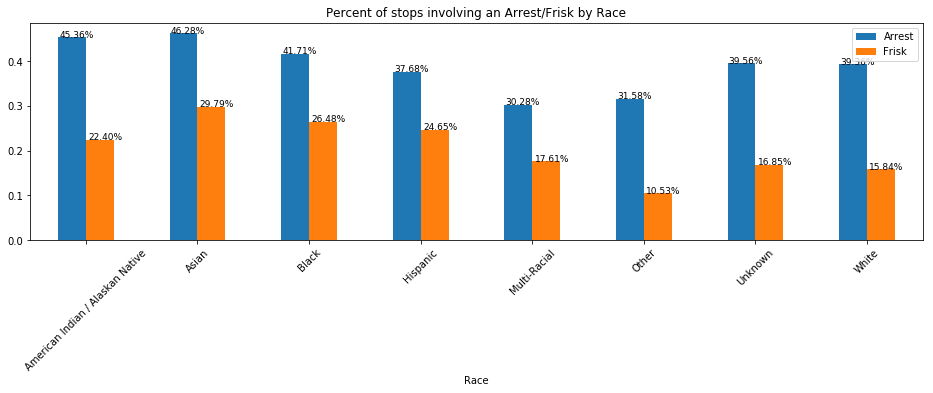

In [12]:
#subset the data
tmp = data[['subject_race', 'arrest', 'frisk','count', 'call_type']]
tmp = tmp[tmp.call_type=='ONVIEW'] 
tmp = tmp.groupby('subject_race')['arrest','frisk','count'].sum()

#generate two new columns of percentages of frisks & arrests
tmp['pct_arrest'] = tmp.apply(lambda x : x['arrest'] / x['count'], axis = 1 )
tmp['pct_frisk']  = tmp.apply(lambda x : x['frisk'] / x['count'], axis = 1 )

tmp.drop(['arrest', 'frisk', 'count'], axis = 1, inplace = True)   # drop the original columns

#plot the data
ax = tmp.plot(kind = 'bar', figsize = (16, 4))

#generate text values above the columns
for i, v in enumerate(tmp.pct_arrest):
    ax.text(i-.24, v, '{:.2f}%'.format(100*v),fontsize = 9 )

for i, v in enumerate(tmp.pct_frisk):
    ax.text(i+.02, v, '{:.2f}%'.format(100*v),fontsize = 9 )

_=plt.xticks(rotation = 45)
_=plt.title('Percent of stops involving an Arrest/Frisk by Race')
_=plt.xlabel('Race')
_=plt.legend(loc = 'best', labels = ['Arrest', 'Frisk'] )

In [13]:
from functools import reduce

In [14]:
t = [(1,2), (3,4), (5,6)]

x = reduce(lambda x, y: x+y ,map(lambda x : x[1], t))
x
#for i in x:
 #   print (i)

12

In [15]:
x = reduce(lambda x, y: x+y ,filter(lambda x: x%2==1,map(lambda x : x[0], t)))
x

9

In [16]:
t = map(lambda t: range(t[0], t[1]), [(1,5), (7,10)])
list(t)

[range(1, 5), range(7, 10)]

In [18]:
import findspark
findspark.init()

IndexError: list index out of range

In [24]:
import os
print(os.environ['SPARK_HOME'])

C:/spark
